# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Instalar dependencias

In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Cargado de bibliotecas

In [2]:
# Datos
import numpy as np
import pandas as pd

# Preprocesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import tensorflow as tf

import joblib

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


2023-05-25 00:56:05.058033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Modo Testing o Kaggle

In [3]:
TESTING = True

### Cargado de Dataset

In [4]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')

#### Trabajo sobre nulos

In [5]:
# Trabajo sobre valores nulos
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

#### Transformacion de variables categoricas

In [6]:
# Transformacion de variables categoricas

import string

# encoding ordinal

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 3},
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)

In [7]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

#### Separacion de datos

In [8]:
# Definicion de excluidos y target

excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]

### Definicion de la funcion metricas

In [9]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Generacion del dataset de prueba

In [10]:
x = ds[features].values
y = ds[target].values

#Separo conjunto de Train y de Test (80/20)
if TESTING: x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state=0, stratify=ds[target])
else:
    x_train = ds[features]
    y_train = ds[target].values

### Escalado

In [11]:
# Vimos que el StandardScaler funciona mejor al entrenar la red
sscaler=StandardScaler()
#sscaler=MinMaxScaler()
x_train = sscaler.fit_transform(x_train)
if TESTING: x_test = sscaler.fit_transform(x_test)
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.005841,-1.629843,0.789827,0.721923,-0.655316,0.074218,0.259688,0.227687,-0.256998,-0.081175,...,2.398055,2.590625,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,-0.167905,-0.228418,1.909289
1,1.242850,1.192710,-0.836485,-0.757367,1.390447,1.080018,0.789056,0.227687,4.838575,-0.081175,...,2.991698,2.590625,4.751219,-0.445401,-0.035953,-0.14259,1.550105,0.118103,-0.228418,0.617433
2,-1.014465,-1.629843,1.440352,1.461568,0.253912,-0.931583,-0.269681,0.227687,-0.256998,-0.081175,...,-0.570159,0.959702,4.751219,-0.445401,-0.035953,-0.14259,-0.222254,-0.868129,-0.228418,0.617433
3,-0.608148,-1.629843,0.139302,0.204172,0.935833,0.074218,-0.269681,0.227687,-0.256998,-0.081175,...,-0.570159,-0.671221,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,0.516792,-0.228418,-0.674424
4,0.520509,-0.218566,0.464565,0.500030,0.253912,-0.931583,0.259688,0.227687,-0.256998,-0.081175,...,-0.570159,-0.671221,-0.325857,-0.445401,-0.035953,-0.14259,-0.222254,0.124398,-0.228418,0.617433


### Modelo

#### Creacion del modelo

In [12]:
inputs = len(pd.DataFrame(x_train).columns)
cant_clases = len(np.unique(y_train))
max_neuronas = 64


# Usamos Early Stopping para prevenir overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
)


# Probamos con funciones de activacion sigmoid y relu y obtuvimos mejores resultados usando relu
# Tambien estamos usando DropOut para prevenir overfitting
modelo = keras.Sequential([
    keras.layers.Dense(max_neuronas,input_shape=(inputs,), activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//4, activation='relu'),
    keras.layers.Dense(max_neuronas//8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    keras.layers.Dense(cant_clases, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelo.compile(
  optimizer=optimizer,
  #loss='mse', 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

2023-05-25 00:56:06.509169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Entrenamiento del modelo usando

In [13]:
epochs = 100
batch_size = 32
if TESTING:
    history = modelo.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test,y_test),
        use_multiprocessing=True,
        callbacks=[early_stopping]
    )
else:
    history = modelo.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verboose=False,
        use_multiprocessing=True,
        callbacks=[early_stopping]
    )

Epoch 1/100
1543/1543 [==============================] - 2s 819us/step - loss: 0.5352 - accuracy: 0.7274 - val_loss: 0.4387 - val_accuracy: 0.7806
Epoch 2/100
1543/1543 [==============================] - 1s 738us/step - loss: 0.4798 - accuracy: 0.7639 - val_loss: 0.4330 - val_accuracy: 0.7743
Epoch 3/100
1543/1543 [==============================] - 1s 728us/step - loss: 0.4708 - accuracy: 0.7698 - val_loss: 0.4182 - val_accuracy: 0.7894
Epoch 4/100
1543/1543 [==============================] - 1s 745us/step - loss: 0.4659 - accuracy: 0.7717 - val_loss: 0.4090 - val_accuracy: 0.7990
Epoch 5/100
1543/1543 [==============================] - 1s 749us/step - loss: 0.4605 - accuracy: 0.7745 - val_loss: 0.4060 - val_accuracy: 0.8039
Epoch 6/100
1543/1543 [==============================] - 1s 741us/step - loss: 0.4539 - accuracy: 0.7807 - val_loss: 0.4019 - val_accuracy: 0.8077
Epoch 7/100
1543/1543 [==============================] - 1s 744us/step - loss: 0.4504 - accuracy: 0.7824 - val_loss: 0

### Metricas del modelo

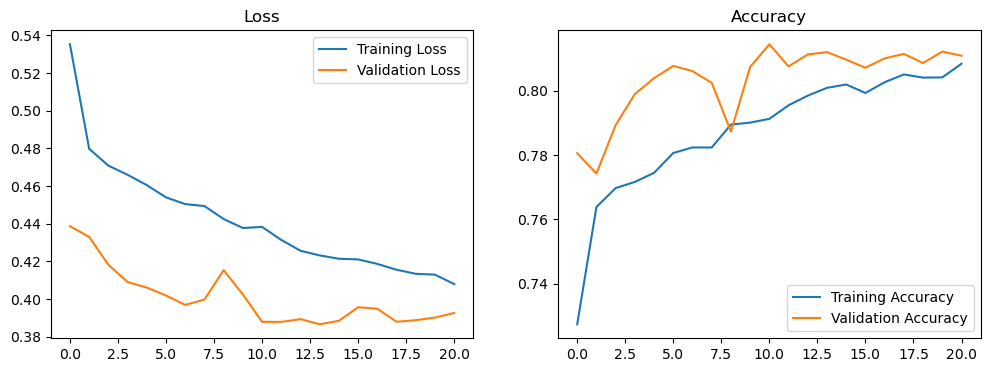

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()